# Networks Project


In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import Counter
from logbin230119 import logbin
import pandas as pd
from scipy import stats

print(pd.__version__)

0.23.4


In [4]:
def fit_log(x,y,plot = True,label = None):
    """
    Input un-logged raw x-y data, returns gradient and intercept
    """
    
    m,c,a,a,a = stats.linregress(np.log10(x),np.log10(y))
    
    if plot == True:
        samp_x = np.arange(min(x),max(x),1)
        plt.loglog(samp_x,samp_x**m * 10 **c,label = label)
    return m,c

# Phase 1: Pure Preferential Attachement

## 1. Barabasi-Albert Model

Add exception error to prevent m > m0

Used a preferential list. Makes a list of of the every edge connection to a vertex. Having a larger number of these causes it to have a higher probability across the whole list. 

In [152]:
class Barabasi_Albert():
    
    def __init__(self,time_limit,m,m_start):
        """
        time_limit: run time until this value
        m: number edges to add every time a new vertex is added
        m0: int, set up initial graph. 
        """
        G0 = nx.complete_graph(m_start) # Start with complete graph, so that unbiased

        flatten = lambda l: [item for sublist in l for item in sublist]
        self.m0 = m_start
        self.m = m
        self.G = G0
        self.preferential_list = flatten([[x]*(m_start-1) for x in range(m_start)])
#         print(self.preferential_list)
        self.time_limit = time_limit
        
        if self.m > m_start:
            raise ValueError("m value must be less than initial graph value")
        
    def drive_pref(self):
        for t in range(self.time_limit):
            node = t + self.m0 #Find the node number
            
            connections = []
            vertices = [node]
            
            for i in range(self.m):
#                 print("i",i)
#                 print(self.preferential_list)
                vertex = random.choice(self.preferential_list)
#                 print(vertices)
                # Prevents multi loops
                while vertex in vertices:
                    vertex = random.choice(self.preferential_list)
                vertices.append(vertex)
    
                link = (node,vertex)
                # Save nodes to connect on graph
                connections.append(link)
                
                # Add to preferential list, one by one if m > 1. add last to prevent self-loops
                self.preferential_list.extend(link)

            self.G.add_node(node)
            self.G.add_edges_from(connections)
            
        df = self._get_counts()
        return df
#             print(connections)
    
    def drive_random(self):
        for t in range(self.time_limit):
            node = t + self.m0 #Find the node number
            
            connections = []
            vertices = [node]
            
            for i in range(self.m):
                nodes = list(self.G.nodes)
                vertex = random.choice(nodes)
                # Prevents multi loops
                while vertex in vertices:
                    vertex = random.choice(nodes)
                vertices.append(vertex)
    
                link = (node,vertex)
                # Save nodes to connect on graph
                connections.append(link)
                
                # Add to preferential list, one by one if m > 1. add last to prevent self-loops
                self.preferential_list.extend(link)

            self.G.add_node(node)
            self.G.add_edges_from(connections)
            
        df = self._get_counts()
        return df
    
    def drive_walk(self,q):
        
        if q == 1:
            raise ValueError("q must be less than 1")
        
        # Create list neighbours from a complete graph
        self.neighbours = [[x for x in range(self.m0) if x !=i] for i in range(self.m0)]
        for t in range(self.time_limit):
            node = t + self.m0 #Find the node number
            connections = [] # Empty List for to list all connections required
            self.neighbours.append([]) # Append empty list for new node
            disallowed_vertices = [node]

            for i in range(self.m):

                # Get list of nodes
                nodes = list(self.G.nodes)
        
                # Pick an initial vertex
                vertex = random.choice(nodes) # Can't pick itself, as not aded to the list yet
                
                # Prevents node from selecting the same vertex as run before from m=0,1,...
                while vertex in disallowed_vertices:
                    vertex = random.choice(nodes) 

                # Continue walking with a probability of q
                while q > random.uniform(0,1):
                    
#                     print("Node = ",node,"Vertex = ",vertex,self.neighbours[vertex],"disallowed",disallowed_vertices)
                    
                    # Choose a neighbour of the target vertex. 
                    vertex = random.choice(self.neighbours[vertex])
                    
                    # Prevents self loops
                    while vertex in disallowed_vertices:
                        vertex = random.choice(self.neighbours[vertex])
                disallowed_vertices.append(vertex)
                        
#                 print("Node = ",node,"Vertex = ",vertex,self.neighbours[vertex],"disallowed",disallowed_vertices)
            
                # Save vertices connected to, used to prevent multi links
                
                # Create tuple to connect nodes
                link = (node,vertex)
                
                # Save neighbours, in an adjacency list. 
                self.neighbours[node].append(vertex)
                self.neighbours[vertex].append(node)
        
                # Save nodes to connect on graph
                connections.append(link)

                
            self.G.add_node(node)
            self.G.add_edges_from(connections)
                            
            
        df = self._get_counts()
        return df
    
    
    def get_degrees(self):
        return np.array(self.preferential_list)
    
    def _get_counts(self):
        counts = dict(Counter(self.preferential_list))
        
#         df = pd.DataFrame(counts.items(), columns=['Node', 'Degrees'])
#         df = df.set_index('Node')
#         return df
    
    def draw(self):
        nx.draw(self.G, with_labels=True, font_weight='bold')

For q ~ 1, will walk randomly for longer, more likley to end up with a node with larger degrees and just has more paths to it, should resemble preferential attachment.

#### Checks

check number of nodes, check number of edges, distrubution of probabilities??

Expect Number of nodes to be: $N_{\text{nodes}} = \text{time}+N_{\text{nodes}}(t=0)$

Expect Number of links to be: $N_{\text{links}} = \frac{1}{2} (m_0-1) m_0$

Expect Number in Preferential List: $N_{\text{pref}} = 2 \cdot \text{time} \cdot m + (m_0-1) m_0 = 2 \times N_{\text{links}} $

Number of Nodes: Expected 12, Obtained 12
Number of Links: Expected 21.0 Obtained 21.0
Number of Preferentials: Expected 42, Obtained 42


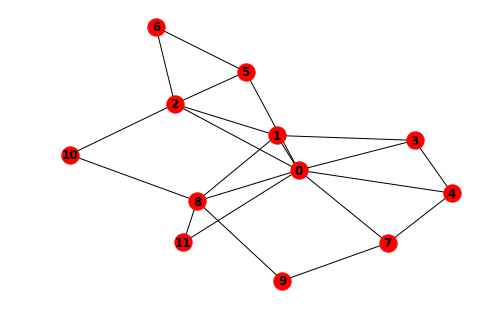

In [32]:
time = 10
m0 = 2
m_test = 2

Ba_test = Barabasi_Albert(time_limit = time,m = m_test,m_start = m0)
degrees = Ba_test.drive_pref()
Ba_test.draw()

preferential_list = Ba_test.get_degrees()
print("Number of Nodes: Expected {}, Obtained {}".format(len(np.unique(preferential_list)),m0+time))
print("Number of Links: Expected {} Obtained {}".format(0.5*(m0-1)*m0+(time*m_test),len(preferential_list)/2))
print("Number of Preferentials: Expected {}, Obtained {}".format(2*(time*m_test)+(m0-1)*m0,len(preferential_list)))


## 2. Best Degree Distribution

Derive from the problem sheet

$$p_{\infty}(k)=\frac{2m(m+1)}{k(k+1)(k+2)}$$

In [204]:
def fit_master_EQ(m,k,plot = True):
#     samp_x = np.arange(min(k),max(k))
    
    p = (2*m*(m+1))/(k*(k+1)*(k+2))
    
    if plot == True:
        plt.plot(k,p,label = r"$p_{\infty}(k)=\frac{2m(m+1)}{k(k+1)(k+2)}$")
    
    return p

You should check that your solution obeys all
known theoretical constraints on the degree distribution

## 3. 

In [195]:
time = 10000

Ba_1 = BA(time_limit = time,m = 2,m_start = 2)
df = Ba_1.run()

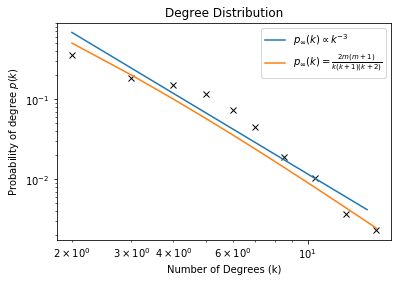

In [391]:
x,y = logbin(df.Degrees,scale = 1.2)
# ax.set_prop_cycle(monochrome)

plt.title("Degree Distribution")
plt.loglog(x,y,'x',color='black')
plt.xlabel("Number of Degrees (k)")
plt.ylabel("Probability of degree $p(k)$")

fit_log(x,y,label = r"$p_{\infty}(k)\propto k^{-3}$")
expected_values = fit_master_EQ(m=2,k=x)
plt.legend()

In [397]:
x,y = logbin(df.Degrees,scale = 1.0)
sum(y)

1.0

In [282]:
stats.chisquare(f_obs = y,f_exp = expected_values)

Power_divergenceResult(statistic=6.165286057029908e-05, pvalue=1.0)

* a small p value means that you reject the null hypothesis, a high p value means you accept the null hypothesis

* for scipy.stats.chisquare - "The chi square test tests the null hypothesis that the categorical data has the given frequencies."

* so the null hypothesis is that the values fit

* so in this case, a high p value means that your fit is very good

* p > 0.95 to indicate very unlikely to be due to randomness

Doyou expect a perfect fit for all value of degree k?


What problems does the fat-tail of this distribution cause? Try to find a way to improve the problems caused by the fat tail

## 4.
Justify choice for m

In [190]:
repeats = 5
m_starting = 2
m_add = 2

degrees_all = []

for time in [1000,10000,100000]:
    print("Calulating time t = ",time)
    degrees_total = [0]*(time+m_starting)
    for N in range(repeats):
        Ba_1 = BA(time_limit = time,m = m_add,m_start = m_starting)
        df = Ba_1.run()
        degrees_total+=df.Degrees.values
#     print(degrees_total)
#     degrees_total = degrees_total/repeats
#     print(degrees_total)
    x,y = logbin(degrees_total,scale = 1.1)
#     plt.figure()
    plt.title("Degree Distribution, (m = {}, m0 = {})".format(m_add,m_starting))
    plt.xlabel("Number of Degrees (k)")
    plt.ylabel("Probability of degree $p(k)$")
    plt.loglog(x,y,label = "t = {}".format(time))
    degrees_all.append(degrees_total)
plt.legend()

#     fit_log(x,y,label = r"$p_{\infty}(k)\propto k^{-3}$")
#     expected_values = fit_master_EQ(m=2,k=x)
#     plt.legend()

Calulating time t =  1000


TypeError: 'Barabasi_Albert' object is not callable

#### Largest Degree $k_1$

Take derivative of degree distribution probability, where maximum at 0:

$$ \frac{d p_{\infty}}{dx} = -\frac{2 m(m+1)\left(3 k^{2}+6 k+2\right)}{k^{2}(k+1)^{2}(k+2)^{2}} = 0$$

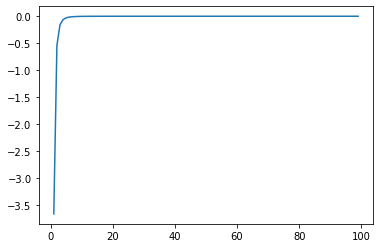

In [298]:
def largest_k(x,m = m_add):
    func = - (2*m *(1 + m)*(2 + 6*x +3*x**2))/(x**2 * (1 + x)**2 * (2 + x)**2)
    return func
samp_x = np.arange(1,100,1)
# largest_k(1)
plt.plot(samp_x,largest_k(samp_x))

First give your best theoretical estimate for the largest expected degree k1. Then use this
to compare against numerical values, in particular variation with N. Can you estimate
errors in any measurements of k1?

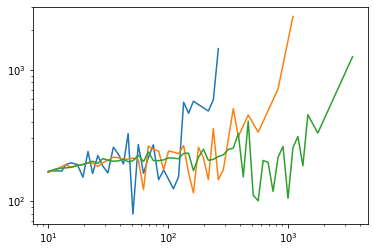

In [319]:
for d in degrees_all:
    x,y = logbin(d,scale = 1.1)
    y /= x**(-3)
#     x /= x**0.1
    plt.loglog(x,y)

## Phase 2: Pure Random Attachment

<BarContainer object of 1002 artists>

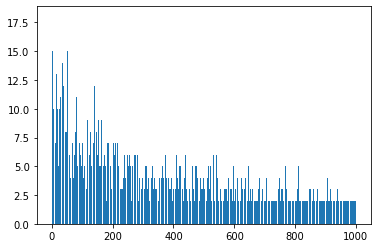

In [389]:
BA = Barabasi_Albert(time_limit = 1000,m=2,m_start=2)
df = BA.drive_random()

plt.bar(df.index,df.Degrees)
# type(list(BA.G.nodes))
# BA.draw()

## Phase 3: Random Walk


No duplicates in Neighbours


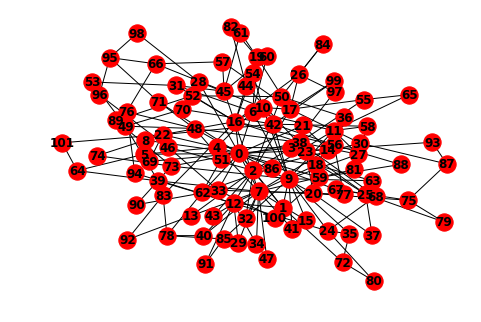

In [192]:
BA = Barabasi_Albert(time_limit = 100 , m=2, m_start = 2)
df = BA.drive_walk(q = 0.5)
BA.draw()
# print(BA.neighbours)
count = 0
for x in BA.neighbours:
    if len(x) != len(np.unique(x)):
        print(count,x)
        print(pd.DataFrame(BA.neighbours))

        raise ValueError("Duplicates in list of neighbours")
    count +=1
print("No duplicates in Neighbours")